# Numerical KDV Solver

Based on test cases in Lamb and Yan, 1996, JPO.

*Dissipation term is not in their paper


$$
\frac{\partial B}{\partial t} = -c \frac{\partial B}{\partial x} + 
2 \epsilon r_{10} c B \frac{\partial B}{\partial x} + \mu r_{01} \frac{\partial^3 B}{\partial x^3}
+ \left(\nu_H \frac{\partial^2 B}{dx^2}\right)
$$

where 

$$
\epsilon = \frac{a_0}{H}
$$

$$
\mu = \frac{H^2}{L_w^2}
$$

$$
r_{01} = -\frac{c \int^1_0 \phi^2\ dz}{ 2 \int^1_0 \phi_z^2\ dz}
$$

$$
r_{10} = \frac{ \int^1_0 (N_z)^2 \phi^3 \ dz}{ 2c^2 \int_0^1 \phi_z^2 \ dz}
$$

original defintion

$$
\left( r_{1,0} = -\frac{ 3\int^1_0 \phi^3 \ dz}{ 4 \int_0^1 \phi_z^2 \ dz} \right)
$$

$\phi(z)$ and $c$ are from eigenvector/value solutions to

$$
\frac{d^2\phi}{dz^2} + \frac{N^2}{c^2}\phi = 0
$$


## Discretized KdV equation

2nd order accurate finite-difference in space and time, explicit (no matrix solve!)

$$
\frac{ B_i^{n+1} - B_i^{n-1} }{2 \Delta t} = -c \frac{ B_{i+1}^{n} - B_{i-1}^{n} }{2 \Delta x} +
2 \epsilon r_{10} c B_i^n \frac{ B_{i+1}^{n} - B_{i-1}^{n} }{2 \Delta x} +
\mu r_{01}  \frac{0.5 B_{i+2}^n - B_{i+1}^n + B_{i-1}^n - 0.5 B_{i-2}^n}{\Delta x^3} +
\left( \nu_H \frac{0.5 B_{i+1}^n - B_{i}^n + 0.5 B_{i-1}^n}{\Delta x^2}\right)
$$

This goes into a matrix problem

$$
\mathbf{A} \mathbf{x} =  \mathbf{b} 
$$

Where the matrix $\mathbf{A}$ has five diagonals containing the finite-difference terms, $\mathbf{x}$ and $\mathbf{b}$ contains the amplitude vector at the old and new time steps, respectively. The upper and lower diagonal also contain the amplitude because of the nonlinear term.

## Streamfunction

The streamfunction, $\psi$, is defined from

$$
u = \psi_z \\
w = -\psi_x
$$

To first order (i.e., to powers of $\epsilon^1$ and $\mu^1$) the streamfunction is

$$
\psi \approx B(x,t)c\phi(z) + \epsilon B^2(x,t) c^2 \phi^{1,0}(z) + \mu B_{xx}(x,t) c \phi^{0,1}(z)
$$

where the structure functions, $\phi^{1,0}$ and $\phi^{0,1}$, share the same power as $\epsilon$ and $\mu$, respectively, i.e., $\phi^{i,j} \sim \mathcal{O}(\epsilon^i \mu^j)$. These are found from solutions to the boundary-value problems


$$
\frac{d^2\phi^{1,0}}{dz^2} + \frac{N^2}{c^2}\phi^{1,0} = 
-2r_{10} \frac{N^2}{c^3}\phi + \frac{1}{c^3} \frac{d}{dz}\left( N^2\right) \phi
$$
and
$$
\frac{d^2\phi^{0,1}}{dz^2} + \frac{N^2}{c^2}\phi^{0,1} = 
-2r_{01} \frac{N^2}{c^3}\phi - \phi
$$

with boundary conditions
$\phi = \phi^{0,1} = \phi^{1,0} = 0$ at $z = 0,\ -H$.

## Buoyancy

Buoyancy, $b=g\rho'$, is given by

$$
b \approx B(x,t)cN^2(z)\phi(z) + \epsilon B^2(x,t) c^2 D^{1,0}(z) + \mu B_{xx}(x,t) c D^{0,1}(z)
$$

The structure functions, $D^{1,0}(z)$ and $D^{0,1}(z)$, are given by

$$
D^{1,0} = \frac{N^2}{c}\phi^{1,0} + r_{10} \frac{N^2}{c^2}\phi
$$

and 

$$
D^{0,1} = \frac{N^2}{c}\phi^{0,1} + r_{0,1}\frac{N^2}{c^2} \phi - \frac{1}{2c^2}\frac{d}{dz}\left( N^2\right) \phi .
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iwaves.utils.isw as kdv
from iwaves.kdv.kdv import  KdV
from iwaves.kdv.kdvimex import  KdVImEx as KdV

import pdb
%matplotlib inline

In [2]:
###########
# Stratification and wave functions
def ideal_rho(z, drho, dp, L):
    #return drho/2 - drho/2*np.tanh(dp + dp*z/L )
    return drho/2 * (1 - np.tanh(dp + dp*z/L ) )

def lamb_rho(z):
    Z = z+300. # Height above the bottom
    return 1027.31 - 3.3955*np.exp((Z-300)/50.0 )

def lamb_drho(z):
    Z = z+300. # Height above the bottom
    return  - 3.3955/50.*np.exp((Z-300)/50.0 )


def lamb_wave(x, a0,  Lw, x0=0.):
    xl = -20000.
    dr = Lw/2
    dl = Lw/2
    return -a0*0.25*(1+np.tanh( (x-xl)/dl))\
        *(1-np.tanh( (x)/dr) )


In [17]:
##########
# Inputs
H = 300.
Nz = 200
#Nx = 16667 # 18 and 9 m
Nx = 15000
z = np.linspace(0, -H, Nz)
#rhoz = ideal_rho(z, 3.1, 3.2, 160.) + 20.6 # Winter
#rhoz = ideal_rho(z, 3.5, 1.8, 150.) + 20.4 # Summer
rhoz = lamb_rho(z)

mode = 0
a0 = 10.
Lw = 200*a0

U0 = 0.942

nondim = False
nonlinear = True
nonhydrostatic= True
ekdv=True
timesolver = 'AB2'

#Cmax=0.04 # Explicit solver
Cmax = 0.8 # IMEX solver
dt = None
runtime = 86400.
#runtime = 1.
#runtime = 5360*5
#runtime = 8000*0.1
###########

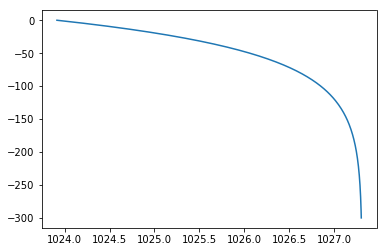

In [18]:
plt.plot(rhoz,z)

In [19]:
###
# Intitialise the class
if nondim:
    runtime = runtime/Lw

mykdv = KdV(rhoz, z, mode=mode, a0=a0, Lw=Lw,\
        Cmax=Cmax, Nx=Nx, nondim=nondim,
        nonlinear=nonlinear,\
        nonhydrostatic=nonhydrostatic,\
        ekdv=False,\
        wavefunc=lamb_wave,\
        timesolver=timesolver,\
        dt=dt)

myekdv = KdV(rhoz, z, mode=mode, a0=a0, Lw=Lw,\
        Cmax=Cmax, Nx=Nx, nondim=nondim,
        nonlinear=nonlinear,\
        nonhydrostatic=nonhydrostatic,\
        ekdv=True,\
        wavefunc=lamb_wave,\
        timesolver=timesolver,\
        dt=dt)

mykdv.print_params()

print 'Lamb values:\n r01 = -2.91e3\n r10 = 8.31e-3\n r20 = 2.35e-5'

Parameters:
 c1 = 0.842245
 epsilon = 1.000000
 mu = 1.000000
 r01 = -2911.224179
 r10 = 0.008310
 r20 = 0.0000235

Lamb values:
 r01 = -2.91e3
 r10 = 8.31e-3
 r20 = 2.35e-5


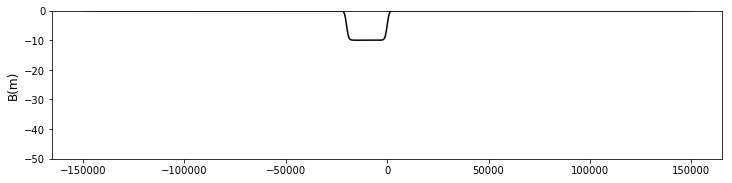

In [20]:
xoffset = 0
########
# Plot the amplitude function
plt.figure(figsize=(12,6))
ax1 = plt.subplot(211)
plt.plot(mykdv.x - xoffset, mykdv.B, color='k')
#plt.plot(mykdv.x - mykdv.c1*runtime, mykdv.B)
#plt.plot(mykdv2.x, mykdv2.B, 'r')
#plt.xlim(-1.1e4, 0.7e4)
plt.ylim(-50, 0)
#plt.xlim(8e4, 10e4)
#plt.xlim(4*Lw, 8*Lw)
plt.ylabel('B(m)')


#ax2 = plt.subplot(212,sharex=ax1)
#plt.plot(mykdv.x - xoffset, u[:,0], color='k')
#plt.ylabel('u [m/s]')
#plt.xlim(-1.1e4, 0.7e4)
#plt.ylim(0,0.5)

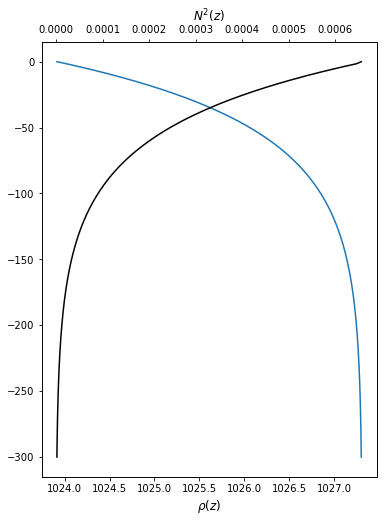

In [21]:
#####
# Plot the density profile
plt.figure(figsize=(6,8))
ax=plt.subplot(111)
plt.plot( mykdv.rhoz, mykdv.z)
plt.xlabel(r'$\rho(z)$')

ax2=ax.twiny()
ax2.plot(mykdv.N2 , mykdv.z,'k')
plt.xlabel('$N^2(z)$')


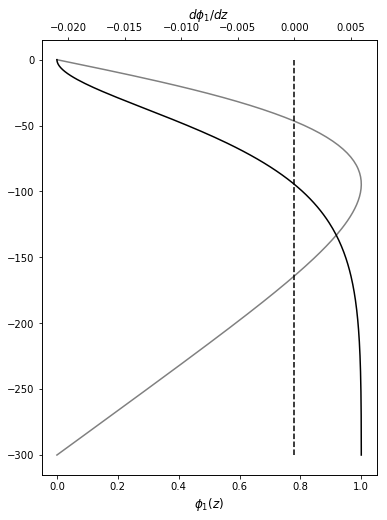

In [22]:
#######
# Plot the eigenfunction (Fig 4 in LY96)
dphi = np.gradient(mykdv.phi_1, -mykdv.dz_s)

plt.figure(figsize=(6,8))
ax=plt.subplot(111)
plt.plot( mykdv.phi_1, mykdv.z,'0.5')
plt.xlabel(r'$\phi_1(z)$')

ax2=ax.twiny()
ax2.plot(dphi , mykdv.z,'k')
ax2.plot([0,0],[-H,0],'k--')
plt.xlabel('$ d \phi_1 / dz$')


In [23]:
####
# Test out the nonlinear correction term solution method
from scipy import linalg
from scipy.optimize import least_squares

def calc_r01(phi, c, dz):
    phi_z = np.gradient(phi, dz)
    num = -c*np.trapz( phi**2., dx=dz)
    den = 2*np.trapz( phi_z**2., dx=dz)
    #num = -c*np.sum( phi**2. * dz)
    #den = 2*np.sum( phi_z**2. * dz)

    return num/den

def calc_phi01_rhs(phi, c, N2, dz):
    r_01 = calc_r01(phi, c, dz)        

    RHS = -2*r_01*N2/c**3.*phi - phi

    return RHS


def calc_D01(phi, c, N2, dz):
    """
    Calculates the first order nonlinear term for buoyancy
    """
    
    r_01 = calc_r01(phi, c, dz) 
    
    phi01rhs = calc_phi01_rhs(phi, c, N2, dz)
    phi01 = solve_phi_bvp(phi01rhs, N2, c, dz)
    
    D01 = N2/c*phi01 + r_01*N2/c**2.*phi 

    return D01#/N2

def calc_phi01(phi, c, N2, dz):
    """
    Calculates the first order nonlinear term for buoyancy
    """
    
    r_01 = calc_r01(phi, c, dz) 
    
    phi01rhs = calc_phi01_rhs(phi, c, N2, dz)
    #phi01 = solve_phi_bvp(phi01rhs, N2, c, dz)
    
    #res_1 = least_squares(fun, phi*-10000., gtol=1e-10,\
    #            args=(phi01rhs, N2, c, dz))
    #return res_1

    # Solve the homogeneous problem firts
    u0 = 1*phi
    idx= np.argwhere(phi==1.)[0][0]
    u0[idx] = 0.
    
    res_1 = least_squares(fun, u0, gtol=1e-10,\
                args=(phi01rhs, N2, c, dz), method='trf')
    
    #res_11 = least_squares(fun, -res_1['x']*1000, gtol=1e-10,\
    #            args=(phi01rhs, N2, c, dz), method='trf')
    return res_1

def calc_phi01_old(phi, c, N2, dz):
    """
    Calculates the first order nonlinear term for buoyancy
    """
    
    r_01 = calc_r01(phi, c, dz) 
    
    phi01rhs = calc_phi01_rhs(phi, c, N2, dz)
    phi01 = solve_phi_bvp(phi01rhs, N2, c, dz)
    return phi01
    
def solve_phi_bvp(B, N2, c, dz):
    """
    Generic solver for the higher-order vertical structure
    functions
    """

    nz = B.shape[0] 
    dz2 = 1/dz**2
    
    ### Construct the LHS matrix, A 
    # (use a dense matrix for now)
    A = np.diag(dz2*np.ones((nz-1)),-1) +\
        np.diag(-2*dz2*np.ones((nz,)) +\
        N2/c**2*np.ones((nz,)) ,0) + \
        np.diag(dz2*np.ones((nz-1)),1)

    # BC's
    eps = 1e-10
    A[0,0] = eps
    A[0,1] = eps
    A[-1,-1] = eps
    A[-1,-2] = eps
    #B[0] = eps
    #B[-1] = eps

    return linalg.solve(A, B)

####
# 
def fun(phi0, B, N2, c, dz):
    """
    Nonline
    """

    nz = B.shape[0] 
    dz2 = 1/dz**2
    
    ### Construct the LHS matrix, A 
    # (use a dense matrix for now)
    #A = np.diag(dz2*np.ones((nz-1)),-1) +\
    #    np.diag(-2*dz2*np.ones((nz,)) +\
    #    N2/c**2*np.ones((nz,)) ,0) + \
    #    np.diag(dz2*np.ones((nz-1)),1)
        
    A = np.diag(dz2*np.ones((nz-1)),-1) +\
        np.diag(-2*dz2*np.ones((nz,)),0) +\
        np.diag(dz2*np.ones((nz-1)),1)

    # BC's
    eps = 0
    A[0,0] = eps
    #A[0,1] = eps
    A[-1,-1] = eps
    #A[-1,-2] = eps
    
    B[0] = eps
    B[-1] = eps
    
    # Remove the RHS
    #A -= np.diag(B,0)

    return A.dot(phi0) + N2/c**2.*phi0 - B



(-8000, 6000)

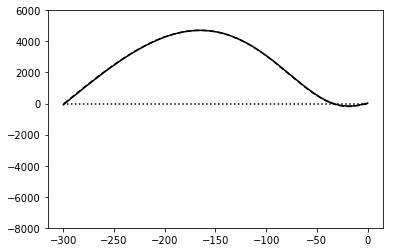

In [24]:
data = calc_phi01(mykdv.phi_1, mykdv.c1, mykdv.N2, mykdv.dz_s)

phi01_old = calc_phi01_old(mykdv.phi_1, mykdv.c1, mykdv.N2, mykdv.dz_s)

#print data
phi01 = data['x']

x = plt.subplot(111)
plt.plot(mykdv.z, phi01,'k-')
plt.plot(mykdv.z, phi01_old,'k--')
plt.plot([-H,0],[0,0],'k:')
plt.ylim(-8000,6000)

(-12000.0, 4000.0)

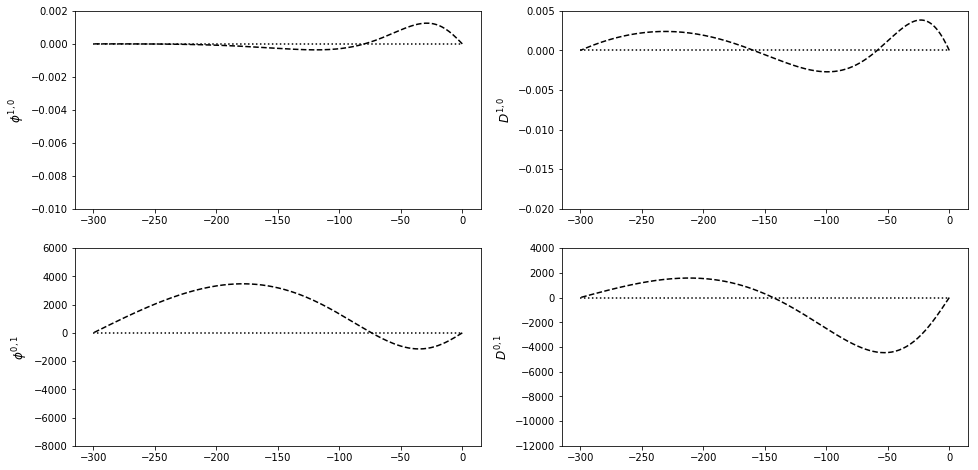

In [25]:
## Calculate nonlinear structure functions phi01, phi10
phi01, phi10 = mykdv.calc_nonlinstructure()

D01 = kdv.calc_D01(mykdv.phi_1, mykdv.c1, mykdv.N2, mykdv.dz_s)/mykdv.N2
D10 = kdv.calc_D10(mykdv.phi_1, mykdv.c1, mykdv.N2, mykdv.dz_s)/mykdv.N2

plt.figure(figsize=(16,8))
ax = plt.subplot(221)
plt.plot(mykdv.z, phi10,'k--')
plt.plot([-H,0],[0,0],'k:')
plt.ylabel('$\phi^{1,0}$')
plt.ylim(-0.01, 0.002)

ax = plt.subplot(222)
plt.plot(mykdv.z, D10,'k--')
plt.plot([-H,0],[0,0],'k:')
plt.ylabel('$D^{1,0}$')
plt.ylim(-0.02, 0.005)

ax = plt.subplot(223)
plt.plot(mykdv.z, phi01,'k--')
plt.plot([-H,0],[0,0],'k:')
plt.ylabel('$\phi^{0,1}$')
plt.ylim(-8000,6000)

ax = plt.subplot(224)
plt.plot(mykdv.z, D01,'k--')
plt.plot([-H,0],[0,0],'k:')
plt.ylabel('$D^{0,1}$')
plt.ylim(-1.2e4, 4e3)

In [ ]:
##########
# run the model
nsteps = int(runtime//mykdv.dt_s)

print nsteps, mykdv.dt_s

for ii in range(nsteps):
    point = nsteps/100
    if(ii % (5 * point) == 0):
        print '%3.1f %% complete...'%(float(ii)/nsteps*100)
    if mykdv.solve_step() != 0:
        print 'Blowing up at step: %d'%ii
        break


4547 18.9981166534
0.0 % complete...


In [13]:
##########
# run the ekdv model
nsteps = int(runtime//myekdv.dt_s)

print nsteps, myekdv.dt_s

for ii in range(nsteps):
    point = nsteps/100
    if(ii % (5 * point) == 0):
        print '%3.1f %% complete...'%(float(ii)/nsteps*100)
    if myekdv.solve_step() != 0:
        print 'Blowing up at step: %d'%ii
        break


4549 18.9922500178
0.0 % complete...
4.9 % complete...
9.9 % complete...
14.8 % complete...
19.8 % complete...
24.7 % complete...
29.7 % complete...
34.6 % complete...
39.6 % complete...
44.5 % complete...
49.5 % complete...
54.4 % complete...
59.4 % complete...
64.3 % complete...
69.2 % complete...
74.2 % complete...
79.1 % complete...
84.1 % complete...
89.0 % complete...
94.0 % complete...
98.9 % complete...


In [14]:
# Calculate the velocity and density fields
rho = mykdv.calc_density(nonlinear=True)
u,w = mykdv.calc_velocity(nonlinear=True)
#psi = mykdv.calc_streamfunction()

(0, 0.5)

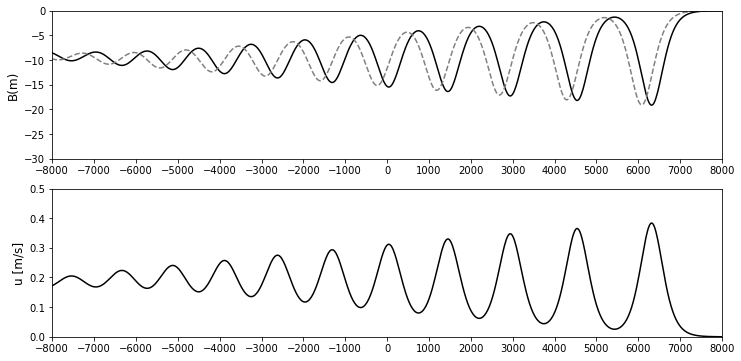

In [15]:
## Comparison with Fig 8 in Lamb and Yan, 1996

xoffset = U0*runtime
xoffset = mykdv.c1*runtime
########
# Plot the amplitude function
plt.figure(figsize=(12,6))
ax1 = plt.subplot(211)
plt.plot(mykdv.x - xoffset, mykdv.B, color='k')
plt.plot(myekdv.x - xoffset, myekdv.B, color='0.5', ls='--')
#plt.plot(mykdv.x - mykdv.c1*runtime, mykdv.B)
#plt.plot(mykdv2.x, mykdv2.B, 'r')
plt.xlim(-0.8e4, .8e4)
plt.xticks(np.arange(-8000,9000,1000))
plt.ylim(-30, 0)
#plt.xlim(8e4, 10e4)
#plt.xlim(4*Lw, 8*Lw)
plt.ylabel('B(m)')


ax2 = plt.subplot(212,sharex=ax1)
plt.plot(mykdv.x - xoffset, u[:,0], color='k')
plt.ylabel('u [m/s]')
plt.xlim(-0.8e4, 0.8e4)
plt.ylim(0,0.5)

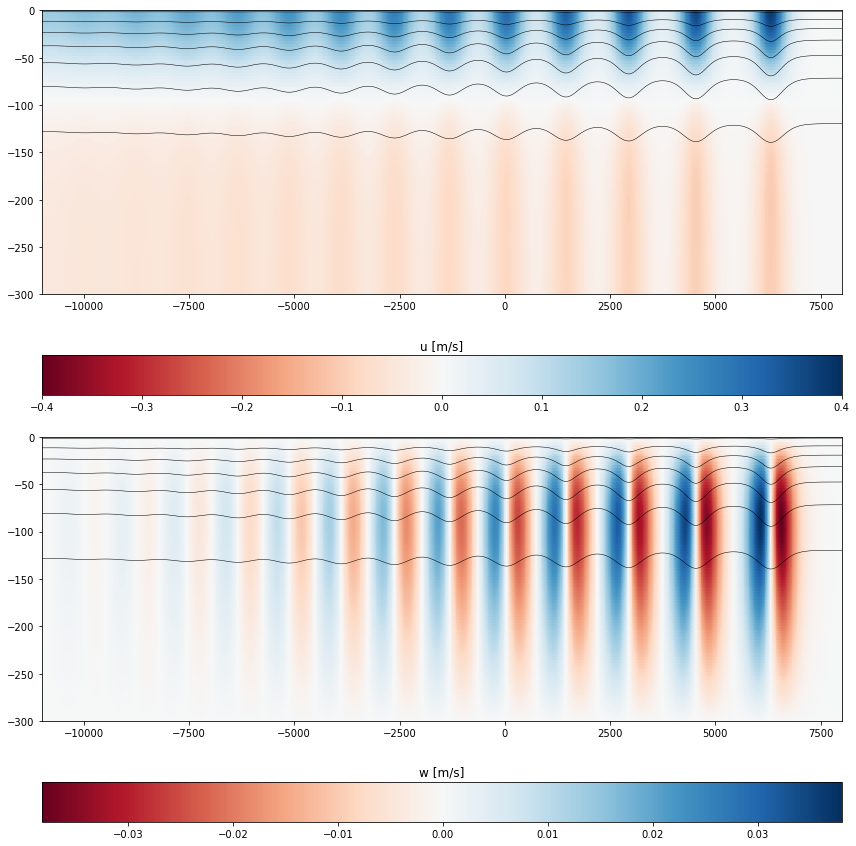

In [16]:
### Plot the density
clims = [-0.4,0.4]

plt.figure(figsize=(12,12))
plt.subplot(211)
plt.pcolormesh(mykdv.x-xoffset, mykdv.z, u.T, 
    vmin=clims[0], vmax=clims[1], cmap='RdBu')
cb=plt.colorbar(orientation='horizontal')
cb.ax.set_title('u [m/s]')
plt.contour(mykdv.x-xoffset, mykdv.z, rho.T, np.arange(20.,30.,0.5),\
        colors='k', linewidths=0.5)

#plt.xlim(-0.8e4, 0.8e4)
plt.xlim(-1.1e4, 0.8e4)

plt.subplot(212)
plt.pcolormesh(mykdv.x-xoffset, mykdv.z, w.T, 
     cmap='RdBu')
cb=plt.colorbar(orientation='horizontal')
cb.ax.set_title('w [m/s]')
plt.contour(mykdv.x-xoffset, mykdv.z, rho.T, np.arange(20.,30.,0.5),\
        colors='k', linewidths=0.5)

#plt.xlim(-0.8e4, 0.8e4)
plt.xlim(-1.1e4, 0.8e4)

plt.tight_layout()